# ISOM 3400 Project WebScraping
# Group 5

In [1]:
from selenium import webdriver
from bs4 import BeautifulSoup
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait as W
from selenium.webdriver.support import expected_conditions as E
from selenium.webdriver import ActionChains
import time
import openpyxl

In [2]:
#excel result saving path
path = 'REST_Analysis_JAPANESE2.xlsx'

# chromedriver excutable_path
executable_path = r'c:\Users\Chan Kin Yan\Desktop\ZOE\BUSI\ISOM\ISOM3400\project\chromedriver.exe'

# Guideline and Expected output from this notebook

## Basic info of this program


**This program will open 432 different webpage with performing more than 760 clicks and expected runtime for finishing is around 3 hours**


**In this program, a execl file will be generated at the begining and rows of information from webscraping will be recored and save during running**
<br>

### Logic flow of this program
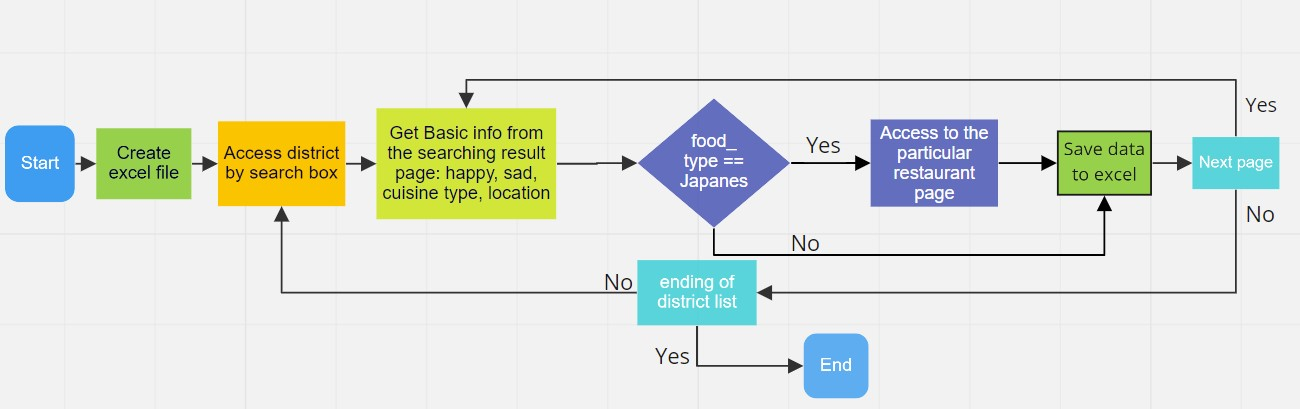

## Expected output


**The following are guildeline and expected output for checking progress of webscraping process**


- **Excel file** name same as path name would be created in same folder and later the other information of restaurants would be recored row by row for each restaurant 
- **"cookie pressing"/"no cookie"**-- a reminding message to show selenium is pressing the cookie button of openrice or not
- In one searching result page, each **restaurant name** would be output for checking it is accessing the information of each restaurant
- number of japanese restaure presents
- **"entering XXX"** will be appear when accessing particular Japanese restaurant, **"going out"** will indicate it return back to the previous searching page
- **all information** by webscraping of all restaurants in this searching page including accessing to paraticular restaurant webpage will be presented
- **"open and save info"** will be appear to indicate it is saving the information to the excel file 
<br> *after **interrupting** the program, information saved would be present in the excel file, plz DO NOT open the excel before interrupting the program, or else other information cannot be recorded and error will happen*
- Chrome will process to the next page
- **done district_name** After all pages of the particlar district are browsed through, it will process to another district using searching feature of the website  _**after 30 mins runtime**_
- _**after 3 hrs**_ total number of japanese restaurants will be presented, the program end

# Helper Function for SAVING DATA 
- **Create excel file**
- **Helper function for loading excel file and appending data from info_list with info of the pages restaurants**

In [3]:
#create an excel file
wb = openpyxl.Workbook(); 
sheet = wb.active; sheet.title = "restaurant_info"
sheet.append(['name', 'price', 'bookmark', 'happy', 'sad', 'food_type','location',
                'num_branch', 'num_seat', 'pay_list', 'other_facility',
                'taste','decor','service','hygiene','value','overall'])
wb.save(path)

In [4]:
#function for sending data to the created workbook
def excel(info_list):
    wb = openpyxl.load_workbook(path) #load back the created excel file
    sheet = wb.active
    for i in info_list: #saving everypage data
        sheet.append(i)
    wb.save(path)  #save the file
    print("open and save info") 

# Helper Function for SORTING DATA
- **Check duplication**
- **Extract numbers from string**

In [5]:
#check duplication
def duplicate(name_list, name):
    if name in name_list:
        return True
    else: 
        name_list.append(name)
        return False

In [6]:
#get number from a string and then return a list 
def get_num(txt):
    return [s for s in txt if s.isdigit()]

# Funtion for SCRAPING DATA from web
- **Get data from particular Japanese restaurant**
- **Get data of multiples restaurants from searching result page** 

In [7]:
# get more info by clicking into the individual restaurant
def get_more_info(bs_more):
    time.sleep(2)
    #get rating
    try:
        rate_list = bs_more.find_all ('div',{'class':'header-score-details-right-item'})
        criteria = {}; total = 0
        for rate_item in rate_list:
            c_name = str(rate_item.find('div',{'class':'header-score-details-right-item-title'}).get_text()) 
            rate = rate_item.find_all('div')[1].attrs['class'][2]
            rate = int(get_num(rate)[0])
            total+=rate
            criteria[c_name]=rate
        criteria['overall']=total
    except:  criteria = 0
        
    # get number of branches
    try:
        num_branch=bs_more.find('section',class_='all-branches-section').a.get_text()
        num_branch=int(''.join(get_num(num_branch)))
    except:
        num_branch = 1

    #narrow down lable and location for following info scraping 
    rest_info = bs_more.find('div',class_='left-col').find('div',class_='or-section-group pois-filter-feature')
    
    # get payment method
    pay_list = [] #store payment method
    try:
        payment = rest_info.find('div',class_="comma-tags").find_all('span')
        for pay in payment:
            pay_list.append(str(pay.get_text()))
        pay_list=','.join(pay_list) # join to be a string for storing to excel
    except: pay_list = 0

    #get num_seat
    try:
        num_seat = str(rest_info.find('div',class_='content'))
        num_seat=int(''.join(get_num(num_seat)))
    except:  num_seat = 0

    # other facility
    try:
        other_info = rest_info.find_all('span',class_='condition-name')
        other_facility = [] # store the info of other facilities
        for item in other_info:
            other_facility+=item.contents
        other_facility = ','.join(other_facility)  # join to be a string for storing to excel
        if other_facility== None: other_facility = 0 #return 0 for indicating nothing for additional facilities
    except: other_facility = 0

    return list(criteria.values()), num_branch, pay_list, num_seat, other_facility


In [8]:
#get info of multiples restaurants from searching result page
def get_info(bs, district, info_list,url):
    global name_list
    item_list =  bs.find_all('section',class_='content-wrapper')
    info_jap=[]

    #get info of each restaurant in the searching result page
    for item in item_list:
        
        #get general info for each restuarant
        name = item.find('h2').a.string
        #check duplication
        if duplicate(name_list,name): continue
        print(name)

        try:
            price = item.find('div',{'class':'icon-info icon-info-food-price'}).span.string
        except AttributeError:
            continue
        
        try:
            bookmark = item.find('div',{'class':'text bookmarkedUserCount js-bookmark-count'}).get("data-count")
        except AttributeError:
            continue

        try:
            sad = item.find('span',{'class':'score highlight'}).string
        except AttributeError:
            continue
        
        try:
            happy = item.find('span',{'class':'score score-big highlight'}).string
        except AttributeError:
            continue
            
        try:
            food_type = item.find('li').string
        except AttributeError:
            continue

        try:
            location = item.find('div',{'class':'icon-info address'}).a.string
            if location != district: continue
        except AttributeError:
            continue

        #save data to a list
        one_res = [name, price, bookmark, happy, sad, food_type, location]
        
        # specially save info of janpanese restaurants for further searching 
        if 'Japan' in food_type:
            global jap; jap+=1
            info_jap.append(one_res)
        else:  # save the info of other types restaurant to the general info list
            info_list.append(one_res); time.sleep(2)
     
    
    #enter new page for extra info for particular Japanese restaurants
    m=0; print(len(info_jap))
    for i in range(len(info_jap)):
        name_japan = info_jap[i][0]
        m=i
        try:
            # click into the individual restaurant
            for i in range(5): # limit of tolerance of failing entering the restaurant page
                try:
                    #click into the page by finding its link using the name of that restaurant
                    moreinfo = W(driver,20).until(E.presence_of_element_located((By.PARTIAL_LINK_TEXT,str(name_japan))))
                    time.sleep(1)
                    moreinfo.click()
                except: # reload the searching result page to find the restaurant link again if any accident happened
                    driver.get(url); time.sleep(5); 
                    if i==4: driver.quit()
                    else: continue
                        
                try:
                    # using bs4 to get the info of the restaurant 
                    time.sleep(2)
                    bs_more=BeautifulSoup(driver.page_source, 'html.parser')
                    bs_more.prettify()
                    if bs_more: break
                except:  # reload from searching result page and redo the pervious poceedures
                    driver.get(url); time.sleep(5)
                    if i==4: driver.quit()
                
                
            #getting more information of the restaurant by calling functions
            try:  
                criteria, num_branch, pay_list, num_seat, other_facility = get_more_info(bs_more)    
                print('getting more')
            except: time.sleep(3) ; continue
                
            print('enter',name_japan)
            
            # go back to the searching result page to continue for other restaurants
            try:
                driver.execute_script("window.history.go(-1)")
                driver.implicitly_wait(1); time.sleep(3);  print('go_out')
            except:
                print('go back failed')
                driver.quit()
        except:
            print('cannot',name_japan); continue

        #save the additional data to the particular list of the restaurant 
        info_jap[m]+= [num_branch, num_seat, pay_list, other_facility]
        for j in criteria:
            info_jap[m].append(j)
        time.sleep(1)

    #sava info of japanese restaurant to info_list containing info in this page
    info_list+=info_jap
    time.sleep(2)

# Main function for navigating to pages and performing webscraping 

- **Launch Chrome driver**
- **Loop through district list to search result for each districts**
- **flipping pages results for each searching of the particular district**
- **Using functions perform webscraping to get information**

In [9]:
# Global variables for later used
url_main = 'https://www.openrice.com' # the major part of openrice website
url_district = ['Mong Kok','Causeway Bay','Central','Tsim Sha Tsui','Yuen Long','Tsuen Wan'] #list of district name we focus
jap = 0 # counting number of japanese restaurants in total
cookie_pressed = False # record whether cookie of the website got pressed
name_list = [] # name list of all the restaurants for checking duplication

In [10]:
#start chrome

#Hide automous control
options = webdriver.ChromeOptions() 
options.add_argument('--disable-blink-features=AutomationControlled')
options.add_argument('--ignore-certificate-errors')
options.add_argument('--ignore-ssl-errors')

# apply chromedriver
driver = webdriver.Chrome(options=options, executable_path=executable_path)
#driver = webdriver.Chrome() # replaced by the version which can hide automous control above

driver.maximize_window()

#Go to website of openrice
driver.get("https://www.openrice.com/en/hongkong/restaurants")

In [11]:
# search for every disticts in list

for district in url_district:
    #find search box
    try:
        search_box = driver.find_element_by_name("where")
        search_box.clear() 
        search_box.send_keys(district)
        search = driver.find_element_by_xpath('//*[@id="header"]/div[2]/div[4]/div/button').click()
        time.sleep(5)
    except:
        print('error'); driver.quit()

    #ready to get info
    endsearch = False #index for to break the loop when finishing searching the result of the district
    url= driver.current_url #get current url preventing from lost after clicking 

    #start to browse through every page of the searching results
    while not endsearch:
        info_list = []  #list for storing information from this page and later be stored into excel
        #cookies
        try:
            if (not cookie_pressed):
                time.sleep(2)
                cookie = W(driver, 20).until(E.presence_of_element_located((By.XPATH,'//*[@id="cookies-agreement"]/div/button')))
                cookie.click()
                cookie_pressed = True
                print('cookie pressing')
        except:
            print("no cookies")

        # get infomation in this page    
        time.sleep(5) #wait for most information present
        bs = BeautifulSoup(driver.page_source, 'html.parser')
        bs.prettify()
        
        # call the webscraping function to perform 
        get_info(bs,district,info_list,url)

        #save data of this page to the excel file
        print(info_list) #print out info list to check the progress of getting the information
        excel(info_list)

        #go to next page
        #find the link of next page 
        time.sleep(3)
        next_page = bs.find('section', {'class':'js-pois-pagination pull-right'}).find('a',class_='pagination-button next js-next')      
        if next_page == None:
            endsearch = True
        else:
            next_page = next_page.attrs['href']
            url=url_main+str(next_page)
            driver.get(url) #go to next page
            time.sleep(10)
            
    print('done',district)

driver.quit()
print(jap) 

cookie pressing
Yadllie Plate
Tearapy 茶聊
Outdark (飛達商業中心)
Mini Friday (銀城廣場)
URBAN Cafe (彌敦道)
Sky726
Ocio (煙廠街)
Lockeroom Dining (朗晴坊)
LAB EAT Restaurant & Bar (T.O.P This is Our Place)
Bellevue Bar and Grill
HeSheEat (白布街)
Pyeong Chang 平昌
Station 3 Cafe 第三站
Double Cafe 孖啡
Aroy Khao Man Gai 阿來泰式地道風味
0
[['Yadllie Plate', '$101-200', '84778', '966', '54', 'Korean', 'Mong Kok'], ['Tearapy 茶聊', '$101-200', '48366', '751', '33', 'International', 'Mong Kok'], ['Outdark (飛達商業中心)', '$201-400', '45405', '819', '20', 'Korean', 'Mong Kok'], ['Mini Friday (銀城廣場)', '$201-400', '47006', '776', '43', 'Western', 'Mong Kok'], ['URBAN Cafe (彌敦道)', 'Below $50', '37955', '831', '5', 'International', 'Mong Kok'], ['Sky726', '$201-400', '77233', '728', '50', ' Asia Miles can be earned on eligible transactions up to HKD10,000.', 'Mong Kok'], ['Ocio (煙廠街)', '$101-200', '38851', '932', '73', 'International', 'Mong Kok'], ['Lockeroom Dining (朗晴坊)', '$101-200', '16090', '702', '0', 'Western', 'Mong Kok'], ['LAB 

Little Fresh Cafe & Bar
Pause It
串Grill 自助燒烤專門店 (廣華街)
La Scala 花月庭
Lady 13 Kitchen (Tung Choi Street) 十三姨 (通菜街)
Jie Genge 桔梗
Nardo's Cafe
Superior Manya Japanese Restaurant 御滿屋日本料理
Fo Shui Lo 火水爐冰室火鍋
Chicken Wings Mountain (T.O.P This is Our Place) 雞翼山 (T.O.P This is Our Place)
Aping Grill 安平燒肉
Maruju Aburi Farm 丸十あぶり牧場
Reiwa Izakaya 令和居酒屋
Romanne Leisure Food Concept (砵蘭街)
A4Noodle 阿四車仔麵
3
getting more
enter Superior Manya Japanese Restaurant 御滿屋日本料理
go_out
getting more
enter Maruju Aburi Farm 丸十あぶり牧場
go_out
getting more
enter Reiwa Izakaya 令和居酒屋
go_out
[['Little Fresh Cafe & Bar', '$101-200', '12318', '263', '0', 'International', 'Mong Kok'], ['Pause It', '$51-100', '21799', '236', '6', 'Western', 'Mong Kok'], ['串Grill 自助燒烤專門店 (廣華街)', '$201-400', '12285', '227', '14', 'Hong Kong Style', 'Mong Kok'], ['La Scala 花月庭', '$201-400', '61049', '384', '84', 'International', 'Mong Kok'], ['Lady 13 Kitchen (Tung Choi Street) 十三姨 (通菜街)', '$51-100', '22496', '191', '7', 'Hong Kong Style', 'Mong 

HK Food 1980 荔香園冰室
Master Beef (Hollywood Plaza) 牛大人台灣火鍋吃到飽 (荷李活商業中心)
NAM VIET NAM CAFÉ 南越南咖啡廳
Hay Wong 喜惶點心專門店
5% Cafe
Little Idea (Tung Choi Street) 小念頭 (通菜街)
Sushi Tachi 立鮨
66 Hot Pot 陸陸雞煲火鍋
Steakhouse@oysterian 平民扒房@友蠔食
Deluxe King Japanese Restaurant 極上帝王水產
Maruju Sushi Japanese Shokudo 丸十寿司日本食堂
Mu Taiwan Noodles (Soy Street) 阿木台灣麵 (豉油街)
Real Stone Grill 堅石燒
Happy Lamb Hot Pot 快樂小羊火鍋餐廳
WOFT
3
getting more
enter Sushi Tachi 立鮨
go_out
getting more
enter Deluxe King Japanese Restaurant 極上帝王水產
go_out
getting more
enter Maruju Sushi Japanese Shokudo 丸十寿司日本食堂
go_out
[['HK Food 1980 荔香園冰室', 'Below $50', '2615', '189', '15', 'Hong Kong Style', 'Mong Kok'], ['Master Beef (Hollywood Plaza) 牛大人台灣火鍋吃到飽 (荷李活商業中心)', '$101-200', '4922', '205', '2', 'Taiwan', 'Mong Kok'], ['NAM VIET NAM CAFÉ 南越南咖啡廳', '$51-100', '5372', '192', '7', 'Vietnamese', 'Mong Kok'], ['Hay Wong 喜惶點心專門店', 'Below $50', '9960', '165', '6', 'Hong Kong Style', 'Mong Kok'], ['5% Cafe', '$101-200', '2650', '170', '3', 'Internatio

Loyi Faateng 老二花廳
Fun Fun 串串鍋
9 3/4 cafe
Mui Kee Cookfood Stall 妹記大排檔
School Food Blooming Mari (T.O.P. This is Our Place)
The Mafe Cafe
Sheng Mian 勝面
Bos Vinci Restaurant & Bar
TEKKA (Dundas Street) 鉄火堂 (登打士街)
R.I.M.K
Sichuan House 川莊
Fungsteak 豐石板燒專門店
Ice Puff
四寶食堂
Tsuki Izakaya 月．火鳳燒鳥
3
getting more
enter TEKKA (Dundas Street) 鉄火堂 (登打士街)
go_out
getting more
enter Fungsteak 豐石板燒專門店
go_out
getting more
enter Tsuki Izakaya 月．火鳳燒鳥
go_out
[['Loyi Faateng 老二花廳', '$101-200', '14454', '71', '5', 'Italian', 'Mong Kok'], ['Fun Fun 串串鍋', '$101-200', '11042', '119', '17', 'Sichuan', 'Mong Kok'], ['9 3/4 cafe', '$101-200', '9438', '134', '11', 'Western', 'Mong Kok'], ['Mui Kee Cookfood Stall 妹記大排檔', '$51-100', '16124', '99', '23', 'Hong Kong Style', 'Mong Kok'], ['School Food Blooming Mari (T.O.P. This is Our Place)', '$51-100', '605', '103', '2', 'Korean', 'Mong Kok'], ['The Mafe Cafe', '$51-100', '6899', '225', '4', 'Italian', 'Mong Kok'], ['Sheng Mian 勝面', '$51-100', '6570', '192', '15', 'Tai

The Sky Bar
串Grill 自助燒烤專門店 (譽發廣場)
Mini Club
Xing Fu Tang 幸福堂
Shun by Kokoro Sushi 鮨心 ，旬節
CR² By Cupping Room (雅蘭中心)
Home Sister 家嫂
The Great Restaurant 一品雞煲火鍋
光榮冰室 (鴻威大厦)
Ichi Shio Kama 一燒窰
2
getting more
enter Shun by Kokoro Sushi 鮨心 ，旬節
go_out
getting more
enter Ichi Shio Kama 一燒窰
go_out
[['The Sky Bar', '$201-400', '8210', '127', '15', 'Western', 'Mong Kok'], ['串Grill 自助燒烤專門店 (譽發廣場)', '$201-400', '1541', '58', '1', 'Hong Kong Style', 'Mong Kok'], ['Mini Club', '$201-400', '7753', '261', '8', 'Western', 'Mong Kok'], ['Xing Fu Tang 幸福堂', 'Below $50', '487', '91', '8', 'Taiwan', 'Mong Kok'], ['CR² By Cupping Room (雅蘭中心)', '$51-100', '1805', '67', '2', 'Western', 'Mong Kok'], ['Home Sister 家嫂', '$101-200', '7524', '49', '13', 'Guangdong', 'Mong Kok'], ['The Great Restaurant 一品雞煲火鍋', '$201-400', '11114', '84', '15', 'Hong Kong Style', 'Mong Kok'], ['光榮冰室 (鴻威大厦)', 'Below $50', '2338', '51', '3', 'Hong Kong Style', 'Mong Kok'], ['Shun by Kokoro Sushi 鮨心 ，旬節', '$401-800', '7249', '100', '2'

Top Blade Steak Lab (希慎道)
Cafe Zense
Xiao Yu Hotpot Restaurant (Jardine Center) 渝味曉宇重慶老火鍋 (渣甸中心)
Lo Spazio
Mr. Steak Buffet à la minute
Gyu Sou Ichuya 牛惣居酎屋
Chili Party (Island Beverley) 麻辣派對 (金百利廣場)
Wulu 胡爐
Sushi Kumo (United Success Commercial Centre) 雲壽司 (聯成商業中心)
Pandan Leaf Indonesian Food 班蘭葉印尼美食
Green Waffle Diner (希慎廣場)
The Drunken Pot (V Point) 酒鍋 (V Point)
FLIPPER'S
A Happy Pancake 幸福班戟
4
getting more
enter Gyu Sou Ichuya 牛惣居酎屋
go_out
getting more
enter Sushi Kumo (United Success Commercial Centre) 雲壽司 (聯成商業中心)
go_out
getting more
enter FLIPPER'S
go_out
getting more
enter A Happy Pancake 幸福班戟
go_out
[['Top Blade Steak Lab (希慎道)', '$101-200', '26129', '351', '7', 'Western', 'Causeway Bay'], ['Cafe Zense', '$101-200', '23456', '378', '5', 'International', 'Causeway Bay'], ['Xiao Yu Hotpot Restaurant (Jardine Center) 渝味曉宇重慶老火鍋 (渣甸中心)', '$201-400', '17046', '460', '6', 'Sichuan', 'Causeway Bay'], ['Lo Spazio', '$201-400', '21458', '491', '10', 'Italian', 'Causeway Bay'], ['Mr. Ste

go_out
getting more
enter Betsutenjin 博多拉麵別天神
go_out
[['Chez Bistro', '$201-400', '12989', '374', '6', 'Western', 'Causeway Bay'], ['Y Pasta', '$101-200', '15889', '429', '21', 'International', 'Causeway Bay'], ['Nom Nom Dumpling 餃掂手工餃子雲吞專門店', 'Below $50', '4907', '261', '6', 'Guangdong', 'Causeway Bay'], ['FRITES Belgium on Tap (曦巒)', '$201-400', '32519', '250', '5', 'Belgian', 'Causeway Bay'], ['U-banquet The Starview 譽宴．星海薈', '$201-400', '2233', '206', '1', 'Guangdong', 'Causeway Bay'], ['瀛豐放題料理專門店', '$201-400', '35648', '334', '64', 'Thai', 'Causeway Bay'], ['Pastaholic (Windsor House) 意粉狂熱 (皇室堡)', '$101-200', '10362', '275', '16', 'Italian', 'Causeway Bay'], ['Sleepless', '$101-200', '7201', '144', '0', 'Western', 'Causeway Bay'], ['Boat Boat Steam 船渦', '$201-400', '18443', '193', '10', 'Hong Kong Style', 'Causeway Bay'], ['Dazzling Cafe (皇室堡)', '$101-200', '11283', '275', '23', ' Asia Miles can be earned on eligible transactions up to HKD10,000.', 'Causeway Bay'], ['Yakiniku Kuma

BASAO tea (白沙道)
No Boundary 無邊
The Coffeeology
NINETYs Roastery
Thaiology
Japanese Wagyu Yakiniku Pure 和牛燒肉‧純
Kin Kin Yakiniku 金金日式燒肉店
10 Shanghai 十里洋場
Siam Noodles (Lan Fong Road) 泰濃麵 (蘭芳道)
Cheung Kung Koon 張公館
Japanese Restaurant Doraya 定食 Doraya
Sushi Kin 鮨金和食料理
Auntie Sweet (Yiu Wa Street） 甜姨姨私房甜品 (耀華街)
Amazing BBQ 一鳴燒
5
getting more
enter Japanese Wagyu Yakiniku Pure 和牛燒肉‧純
go_out
getting more
enter Kin Kin Yakiniku 金金日式燒肉店
go_out
getting more
enter Japanese Restaurant Doraya 定食 Doraya
go_out
getting more
enter Sushi Kin 鮨金和食料理
go_out
getting more
enter Amazing BBQ 一鳴燒
go_out
[['BASAO tea (白沙道)', '$51-100', '8167', '92', '4', 'International', 'Causeway Bay'], ['No Boundary 無邊', '$101-200', '10772', '89', '6', 'International', 'Causeway Bay'], ['The Coffeeology', '$51-100', '10164', '78', '1', 'Western', 'Causeway Bay'], ['NINETYs Roastery', '$201-400', '6435', '100', '2', 'Western', 'Causeway Bay'], ['Thaiology', '$101-200', '5363', '108', '1', 'Thai', 'Causeway Bay'], ['10 Shangh

go_out
getting more
enter Kyo Hayashiya (Hysan Place) 京林屋 (希慎廣場)
go_out
getting more
enter Sushi Itsu 鮨逸
go_out
getting more
enter Yaki Oni 燒鬼
go_out
getting more
enter Fujisan 富士山
go_out
[['Chun Giu 春嬌', '$51-100', '1847', '92', '0', 'Vietnamese', 'Causeway Bay'], ["King's Delicacy (Fashion Walk) 京滬佳餚 (Fashion Walk)", '$201-400', '3355', '87', '2', 'Guangdong', 'Causeway Bay'], ['Lady BoBo 圓圓小姐', 'Below $50', '1823', '87', '0', 'Taiwan', 'Causeway Bay'], ['Kam Kee Cafe (Sharp Street East) 金記冰室 (霎東街)', '$51-100', '7333', '171', '13', 'Hong Kong Style', 'Causeway Bay'], ['PLAYT PLAYT 咖啡廳', '$401-800', '12760', '158', '6', 'Western', 'Causeway Bay'], ['Milksha 迷客夏', 'Below $50', '3686', '107', '12', 'Taiwan', 'Causeway Bay'], ['Chicken Wings Mountain (Jaffe Road) 雞翼山 (謝斐道)', '$51-100', '4152', '128', '3', 'Hong Kong Style', 'Causeway Bay'], ['Little Bao 小包包', '$101-200', '7626', '72', '3', 'International', 'Causeway Bay'], ['Kozy Okonomi-yaki Teppan-yaki', '$201-400', '25130', '96', '10'

KAGURA 牡蠣小屋
Outback Steakhouse (翡翠明珠廣場)
Chung Kee Cafe 忠記咖啡屋‧私房菜
樂湯雞麵館 (登龍街)
Ultimate Golden Pot 滿漢金鍋
Life Toast (希雲街)
As You Like Restaurant 隨變火鍋
An Nam (Lee Gardens) 安南 (利園)
1
getting more
enter KAGURA 牡蠣小屋
go_out
[['Outback Steakhouse (翡翠明珠廣場)', '$201-400', '9925', '307', '60', 'Australian', 'Causeway Bay'], ['Chung Kee Cafe 忠記咖啡屋‧私房菜', '$101-200', '4239', '150', '3', 'Hong Kong Style', 'Causeway Bay'], ['樂湯雞麵館 (登龍街)', '$51-100', '2195', '56', '0', 'Hong Kong Style', 'Causeway Bay'], ['Ultimate Golden Pot 滿漢金鍋', '$201-400', '1217', '94', '0', 'Guangdong', 'Causeway Bay'], ['Life Toast (希雲街)', '$51-100', '5662', '44', '0', 'Western', 'Causeway Bay'], ['As You Like Restaurant 隨變火鍋', '$201-400', '6281', '220', '1', 'Guangdong', 'Causeway Bay'], ['An Nam (Lee Gardens) 安南 (利園)', '$201-400', '13481', '86', '5', 'Vietnamese', 'Causeway Bay'], ['KAGURA 牡蠣小屋', '$201-400', '4239', '48', '1', 'Japanese', 'Causeway Bay', 1, 30, 'Visa,Master,Cash', 'Online Reservation', 4, 4, 4, 4, 4, 20]]
open 

Caprice
The Chairman 大班樓
Mom's Dry Noodles (Park Central) 老媽拌麵 (將軍澳中心)
Sukiyaki Mori (Hollywood Road) すき焼 森 (荷李活道)
Pho Bar
Green Waffle Diner (嘉咸街)
Baked
SHÈ 舍
Korean Loft Cafe 韓閣
Barista by Givrés
HoLanJeng 何蘭正
Maru De Sankaku ○de▽ 鯛白湯らーめん
Mirror & Vegan Concept
Tealosophy Tea Bar (Wyndham Street) 汴京茶寮 (雲咸街)
2
getting more
enter Sukiyaki Mori (Hollywood Road) すき焼 森 (荷李活道)
go_out
getting more
enter Maru De Sankaku ○de▽ 鯛白湯らーめん
go_out
[['Caprice', 'Above $801', '22333', '247', '15', 'French', 'Central'], ['The Chairman 大班樓', '$401-800', '24234', '215', '10', 'Guangdong', 'Central'], ['Pho Bar', '$51-100', '7432', '171', '10', 'Vietnamese', 'Central'], ['Green Waffle Diner (嘉咸街)', '$101-200', '17252', '319', '20', 'Western', 'Central'], ['Baked', '$101-200', '13757', '87', '7', 'Western', 'Central'], ['SHÈ 舍', '$201-400', '16335', '95', '15', 'Hong Kong Style', 'Central'], ['Barista by Givrés', 'Below $50', '7163', '144', '3', 'Western', 'Central'], ['HoLanJeng 何蘭正', '$101-200', '6272', 

open and save info
Café Life Patisserie & Cafe (太興中心)
Mom's Dry Noodles (Shun Tak Centre) 老媽拌麵 (信德中心)
Bakehouse
The Lounge
The French Window
Cafe Seasons 四季常餐
Mee...lemongrass (將軍澳中心)
TENKAI 天海
New Punjab Club
Spiga
Zuma Hong Kong
Lawry’s The Prime Rib
Cafe MED 熊小館
Braza Churrascaria Brazilian Steakhouse
1935 Restaurant 1935 壹玖叁伍
2
getting more
enter TENKAI 天海
go_out
getting more
enter Zuma Hong Kong
go_out
[['Bakehouse', '$51-100', '7207', '52', '0', 'Western', 'Central'], ['The Lounge', '$101-200', '5840', '191', '12', 'Western', 'Central'], ['The French Window', '$401-800', '16390', '108', '25', 'Western', 'Central'], ['Cafe Seasons 四季常餐', 'Below $50', '3529', '66', '5', 'Hong Kong Style', 'Central'], ['New Punjab Club', 'Above $801', '11518', '56', '1', 'Indian', 'Central'], ['Spiga', '$401-800', '19335', '51', '4', ' Asia Miles can be earned on eligible transactions up to HKD10,000.', 'Central'], ['Lawry’s The Prime Rib', '$401-800', '11986', '45', '5', 'American', 'Central'], ['B

open and save info
Tonkichi Tonkatsu Seafood (IFC) 丼吉日式吉列豬排專門店 (國際金融中心)
Golden Thai 金坊泰國美食
Asian Cooking 薈亞廚房
Vive Cake Boutique
Mandarin Grill + Bar 文華扒房及酒吧
Écriture
Green Common (將軍澳中心)
The Chinese Banks' Association Ltd 香港華商銀行公會
alfafa Cafe
RUBIA
R&R Bagels
Kind Kitchen
Luk Yu Tea House 陸羽茶室
1
getting more
enter Tonkichi Tonkatsu Seafood (IFC) 丼吉日式吉列豬排專門店 (國際金融中心)
go_out
[['Vive Cake Boutique', '$51-100', '5244', '65', '4', 'Western', 'Central'], ['Mandarin Grill + Bar 文華扒房及酒吧', 'Above $801', '10403', '97', '8', 'Western', 'Central'], ['Écriture', 'Above $801', '12869', '41', '7', 'French', 'Central'], ["The Chinese Banks' Association Ltd 香港華商銀行公會", '$101-200', '2472', '140', '2', 'Guangdong', 'Central'], ['alfafa Cafe', '$51-100', '514', '51', '0', 'Western', 'Central'], ['RUBIA', '$401-800', '7304', '28', '3', 'Spanish', 'Central'], ['R&R Bagels', '$51-100', '9179', '68', '9', 'Western', 'Central'], ['Kind Kitchen', '$101-200', '7443', '48', '10', 'International', 'Central'], ['Lu

go_out
getting more
enter Tea Brush 茶墨
go_out
getting more
enter Gram cafe & pancakes
go_out
getting more
enter Sushi Tokumi 德美壽司
go_out
getting more
enter Mokumoku Yakiton (厚福街)
go_out
[['2DP', '$101-200', '29099', '793', '51', 'Western', 'Tsim Sha Tsui'], ['Hanook Korean Restaurant 韓屋', '$101-200', '23659', '471', '35', 'Korean', 'Tsim Sha Tsui'], ['Odelice! (The ONE)', '$201-400', '36718', '573', '20', 'French', 'Tsim Sha Tsui'], ['ATUM Restaurant', '$201-400', '53920', '587', '32', 'Western', 'Tsim Sha Tsui'], ['Cambo ขุนทอง (The ONE)', '$101-200', '46749', '720', '83', 'Thai', 'Tsim Sha Tsui'], ['Le Viet', '$101-200', '23033', '612', '26', 'Vietnamese', 'Tsim Sha Tsui'], ['Wulu Restaurant 醉胡爐', '$201-400', '21047', '619', '7', 'Hong Kong Style', 'Tsim Sha Tsui'], ['Goobne Chicken (The Hart)', '$101-200', '48932', '668', '20', 'Korean', 'Tsim Sha Tsui'], ['Sun Thai Restaurant 新泰東南亞餐廳', '$101-200', '11150', '492', '7', 'Thai', 'Tsim Sha Tsui'], ['Yakiniku More 牛魔', '$201-400', '2091

Ajidouraku (Hanoi Road) 味道樂居酒屋 (河內道)
8Pots HK (Kimberley Road) 8鍋臭臭鍋 (金巴利道)
BRICK LANE Gallery
Ramen Bari-Uma (Kimberley Road) 霸嗎拉麵 (金巴利道)
Morton's of Chicago
HAND3AG
5
getting more
enter KUROMON AQUATIC JAPANESE RESTAURANT 黑門水產すいさん
go_out
getting more
enter PAN de PAIN Pancake & Sweets
go_out
getting more
enter Akita Hamayaki 秋田浜燒食堂
go_out
getting more
enter Ajidouraku (Hanoi Road) 味道樂居酒屋 (河內道)
go_out
getting more
enter Ramen Bari-Uma (Kimberley Road) 霸嗎拉麵 (金巴利道)
go_out
[['XIHEYAYUAN 羲和雅苑', '$401-800', '26678', '478', '57', 'Beijing', 'Tsim Sha Tsui'], ['Fukuoka Hambageu 福岡漢堡扒', '$101-200', '9030', '268', '7', 'Korean', 'Tsim Sha Tsui'], ['8Five2 Restobar', '$101-200', '12487', '282', '4', 'Mexican', 'Tsim Sha Tsui'], ['Master Beef (Carnarvon Plaza) 牛大人台灣火鍋吃到飽 (加拿芬廣場)', '$101-200', '13967', '226', '7', 'Taiwan', 'Tsim Sha Tsui'], ['Hancham Korean BBQ Restaurant (Empire Centre) 韓珍 (帝國中心)', '$201-400', '13378', '255', '5', 'Korean', 'Tsim Sha Tsui'], ['8Pots HK (Kimberley Road) 8鍋臭臭鍋 (金

open and save info
Sushi Ma Japanese Restaurant 鮨真
Grand Hill Taiwanese Restaurant 圓山台灣料理
Baroness （Houng Sun Building） 小黑糖 (宏生大廈）
Sweet Button 小糖鈕
Cafe, Hyatt Regency Tsim Sha Tsui
Heisei 平成
光榮冰室 (厚福街)
Kailash Parbat
Water Gate Chicken Rice (Mangan Building) 水門雞飯 (萬勤商業大廈)
Lung Mun Cafe 瓏門冰室
Velo Italian Bar & Grill
Anjappar Chettinad Indian Restaurant
Vego Coffee 齋啡
LIFETASTIC Patisserie (The ONE)
2
getting more
enter Sushi Ma Japanese Restaurant 鮨真
go_out
getting more
enter Heisei 平成
go_out
[['Grand Hill Taiwanese Restaurant 圓山台灣料理', '$201-400', '15004', '574', '8', 'Taiwan', 'Tsim Sha Tsui'], ['Baroness （Houng Sun Building） 小黑糖 (宏生大廈）', 'Below $50', '4249', '259', '4', 'Taiwan', 'Tsim Sha Tsui'], ['Sweet Button 小糖鈕', '$51-100', '8097', '258', '4', 'Western', 'Tsim Sha Tsui'], ['Cafe, Hyatt Regency Tsim Sha Tsui', '$401-800', '48097', '256', '47', 'International', 'Tsim Sha Tsui'], ['光榮冰室 (厚福街)', 'Below $50', '8108', '201', '9', 'Hong Kong Style', 'Tsim Sha Tsui'], ['Kailash Parbat',

open and save info
The Food Gallery
Empire City Roasted Duck 大都烤鴨
Lady Nara
AFURI Ramen + Dumpling (The ONE) 阿夫利拉麵 (The ONE)
Greyhound Café Galleria (Victoria Dockside K11 Musea)
Kappo Ro Ann (iSQUARE) 割烹 櫓杏 (iSQUARE國際廣場)
Jan Jan Kushikatsu Jan Jan 串揚專門店
Kyoto Ichinoden 京都一の傳
The Blind Pig (諾士佛臺)
ANA TEN 天穴
Dang Wen Li by Dominique Ansel 當文歷餅店 by Dominique Ansel
東京食堂
ÉPURE
Fu Rong (Ocean Terminal) 映水芙蓉 (海運大廈)
5
getting more
enter AFURI Ramen + Dumpling (The ONE) 阿夫利拉麵 (The ONE)
go_out
getting more
enter Kappo Ro Ann (iSQUARE) 割烹 櫓杏 (iSQUARE國際廣場)
go_out
getting more
enter Kyoto Ichinoden 京都一の傳
go_out
getting more
enter ANA TEN 天穴
go_out
getting more
enter 東京食堂
go_out
[['The Food Gallery', '$401-800', '48342', '138', '49', 'Western', 'Tsim Sha Tsui'], ['Empire City Roasted Duck 大都烤鴨', '$101-200', '23820', '170', '26', 'Shanghai', 'Tsim Sha Tsui'], ['Lady Nara', '$101-200', '10753', '114', '6', 'Western', 'Tsim Sha Tsui'], ['Greyhound Café Galleria (Victoria Dockside K11 Musea)', '$101-20

open and save info
Poseidon Restaurant & Bar
Bayfare Social
Yamm
Kinabaji Korean Cafe and Restaurant 奇納百川
Tripodking (Kimberley Road) 鼎王麻辣鍋 (金巴利道)
Pasticceria Giovanni Pina 1920 (K11 Musea)
The Tiffany Blue Box Cafe
Cucina
Med Chef
0
[['Poseidon Restaurant & Bar', '$201-400', '7938', '124', '4', 'International', 'Tsim Sha Tsui'], ['Bayfare Social', '$201-400', '13790', '67', '5', 'Western', 'Tsim Sha Tsui'], ['Yamm', '$401-800', '27030', '360', '123', 'International', 'Tsim Sha Tsui'], ['Kinabaji Korean Cafe and Restaurant 奇納百川', '$201-400', '5026', '113', '19', 'Korean', 'Tsim Sha Tsui'], ['Tripodking (Kimberley Road) 鼎王麻辣鍋 (金巴利道)', '$201-400', '11750', '139', '7', 'Taiwan', 'Tsim Sha Tsui'], ['Pasticceria Giovanni Pina 1920 (K11 Musea)', '$101-200', '4872', '111', '3', 'Italian', 'Tsim Sha Tsui'], ['The Tiffany Blue Box Cafe', '$201-400', '9237', '90', '5', 'Western', 'Tsim Sha Tsui'], ['Cucina', '$401-800', '17156', '171', '14', 'Italian', 'Tsim Sha Tsui'], ['Med Chef', '$101-200', 

Menya Kaku 麺屋·隠
2
getting more
enter Gyuugoku Stone Grill Steak (Ho Shun Lee Building) 牛極 (好順利大廈)
go_out
getting more
enter Menya Kaku 麺屋·隠
go_out
[['B+BC cafe 桂花小幸', '$51-100', '1363', '107', '3', 'Taiwan', 'Yuen Long'], ['Old Fung Tea House (Tai Tong Road) 老馮茶居 (大棠路)', '$51-100', '11194', '101', '9', 'Hong Kong Style', 'Yuen Long'], ['Hoi Yat Cafe 凱逸餐室', '$51-100', '1212', '116', '1', 'Hong Kong Style', 'Yuen Long'], ['Mini Bangkok Thai Food (Kau Yuk Road) 小曼谷泰國美食 (教育路)', '$101-200', '3334', '130', '4', 'Thai', 'Yuen Long'], ['Oyster Season', '$201-400', '4791', '141', '1', 'Peruvian', 'Yuen Long'], ['Salamat Cafe', '$101-200', '4778', '103', '3', 'International', 'Yuen Long'], ['龍鳳店', '$51-100', '11542', '93', '5', 'Hong Kong Style', 'Yuen Long'], ['Cafe 52', 'Below $50', '3754', '64', '2', 'Western', 'Yuen Long'], ['616牛肉火鍋專門店 (西菁街)', '$101-200', '14004', '167', '6', 'Hong Kong Style', 'Yuen Long'], ['INN - I’m Not Nothing', '$51-100', '4431', '83', '4', 'International', 'Yuen Long

open and save info
沐淳
Tenya 天丼
MODERN STAND LANE 摩登士丹里
香蕉仔
Sole Coffee
公車泰國餐廳
Sing Kee Cafe 成記茶寮
Wa Yuan Restaurant 華苑酒家
Man Fong Cafe (Kin Tak Street) 萬芳冰室 (建德街)
小鍋米線
TOMATO C HING 番茄師兄
Tanaka Japanese Restaurant 田中日本料理
Fatty Lai 肥仔黎
PizzaExpress (形點)
Squirrel Burger (Yee Fung Garden) 小松鼠 (怡豐花園)
2
getting more
enter Tenya 天丼
go_out
getting more
enter Tanaka Japanese Restaurant 田中日本料理
go_out
[['沐淳', 'Below $50', '259', '43', '0', 'Taiwan', 'Yuen Long'], ['MODERN STAND LANE 摩登士丹里', 'Below $50', '1703', '78', '4', 'Hong Kong Style', 'Yuen Long'], ['香蕉仔', 'Below $50', '4538', '29', '0', 'Thai', 'Yuen Long'], ['Sole Coffee', '$51-100', '1195', '40', '0', 'International', 'Yuen Long'], ['公車泰國餐廳', '$101-200', '330', '54', '0', 'Thai', 'Yuen Long'], ['Sing Kee Cafe 成記茶寮', 'Below $50', '8222', '100', '5', 'Hong Kong Style', 'Yuen Long'], ['Wa Yuan Restaurant 華苑酒家', '$51-100', '691', '102', '8', 'Guangdong', 'Yuen Long'], ['Man Fong Cafe (Kin Tak Street) 萬芳冰室 (建德街)', '$51-100', '5852', '95', '2

Sora Cafe
Chow Chow Cafe
立哥麵家
Moment Cafe
肥仔海南雞專門店
Brotzeit German Bier Bar & Restaurant (形點)
Ho To Tai Noodle Shop 好到底麵家
Sakura 桜
Prince Kitchen 王子私房菜
2
getting more
enter Gyu-Kaku (Yuen Long Plaza) 牛角日本燒肉專門店 (元朗廣場)
go_out
getting more
enter Sakura 桜
go_out
[['Tai Wing Wah Restaurant 大榮華酒樓', '$101-200', '5292', '261', '53', 'Hong Kong Style', 'Yuen Long'], ['Chicken Pot Hut 雞煲棧火鍋', '$101-200', '2655', '26', '1', 'Hong Kong Style', 'Yuen Long'], ['古月聚台灣古早味美食', 'Below $50', '3790', '38', '5', 'Taiwan', 'Yuen Long'], ['蘇記流心燉蛋專門店', 'Below $50', '5425', '33', '4', 'Guangdong', 'Yuen Long'], ['Sora Cafe', '$51-100', '2406', '23', '0', 'Western', 'Yuen Long'], ['Chow Chow Cafe', '$101-200', '2190', '58', '10', 'Western', 'Yuen Long'], ['立哥麵家', '$51-100', '3531', '51', '4', 'Hong Kong Style', 'Yuen Long'], ['Moment Cafe', '$51-100', '4075', '54', '10', 'Western', 'Yuen Long'], ['肥仔海南雞專門店', 'Below $50', '1695', '31', '2', 'Thai', 'Yuen Long'], ['Brotzeit German Bier Bar & Restaurant (形點)', '$2

open and save info
Uchi City Stone Grill House 牛県
Toriyamana 鳥山名
Spicy Restaurant 麻辣風雲
CHAN•TAIWAN CUISINE 饞•台式幸福食堂
Captain Japanese & Korean Restaurant (Sha Tsui Road) 校長燒肉日韓料理 (沙咀道)
CAFE 2.0 茶餐廳2.0
KOKON2 (Kolour Tsuen Wan) 古今二 (荃灣千色匯)
Cafe Swan (KOLOUR Tsuen Wan) 咖啡灣 (荃灣千色匯)
老闆娘雲南米線
You You (Winning Heights) 你妳 (運通洋樓)
Peko Peko Eatery (OP Mall) Peko Peko Eatery (海之戀商場)
Wenger Noodle 雲家小鍋米線
Leisurely Veggie 天 · 悠蔬食
Daily 13
3
getting more
enter Uchi City Stone Grill House 牛県
go_out
getting more
enter Toriyamana 鳥山名
go_out
getting more
enter KOKON2 (Kolour Tsuen Wan) 古今二 (荃灣千色匯)
go_out
[['Spicy Restaurant 麻辣風雲', '$101-200', '11216', '354', '13', 'Sichuan', 'Tsuen Wan'], ['CHAN•TAIWAN CUISINE 饞•台式幸福食堂', '$51-100', '3937', '222', '2', 'Taiwan', 'Tsuen Wan'], ['Captain Japanese & Korean Restaurant (Sha Tsui Road) 校長燒肉日韓料理 (沙咀道)', '$101-200', '13254', '287', '13', 'Korean', 'Tsuen Wan'], ['CAFE 2.0 茶餐廳2.0', 'Below $50', '2671', '324', '24', 'Hong Kong Style', 'Tsuen Wan'], ['Cafe Swan (KO

open and save info
Lao Zhang Gui Dongbei Restaurant (OP Mall) 老掌櫃東北菜館 (海之戀商場)
hōmu by favilla
Butadouraku (Tai Ho Road) 豚道樂 (大河道)
Twenty First 廿一前
Pickabowl (荃新天地)
CHA FAN 叁茶陸飯
OS Plus (Citywalk) 蠔站 (荃新天地)
Twelve Flavors (Nina Tower) 十二味 (如心廣場)
El Cerdo (Tai Pa Street) El Cerdo (大壩街)
La Postre (荃灣廣場)
Menyafuku 麵屋福
Le Saigon Cuisine 小越廚
Ding Lee 鼎家喜筷
友拉麵
Lucky Smash
5
getting more
enter hōmu by favilla
go_out
getting more
enter Butadouraku (Tai Ho Road) 豚道樂 (大河道)
go_out
getting more
enter Twenty First 廿一前
go_out
getting more
enter Menyafuku 麵屋福
go_out
getting more
enter 友拉麵
go_out
[['Lao Zhang Gui Dongbei Restaurant (OP Mall) 老掌櫃東北菜館 (海之戀商場)', '$51-100', '12552', '85', '13', 'Northeastern', 'Tsuen Wan'], ['Pickabowl (荃新天地)', '$51-100', '3452', '101', '1', 'International', 'Tsuen Wan'], ['CHA FAN 叁茶陸飯', '$51-100', '9082', '219', '40', 'Taiwan', 'Tsuen Wan'], ['OS Plus (Citywalk) 蠔站 (荃新天地)', '$201-400', '16878', '109', '27', 'Western', 'Tsuen Wan'], ['Twelve Flavors (Nina Tower) 十二味 (如心廣場

open and save info
IKEA Restaurant & Cafe 宜家家居餐廳及咖啡室
Jinseki Steak and Seafood (Nina Tower) 神石燒牛扒水產專門店 (如心廣場)
MEOKBANG KOREAN BBQ & BAR (Citywalk) 炑八韓烤 (荃新天地)
A Boutea (OP Mall) 花斑茶社 (海之戀商場)
Bench Cafe
Diff. Cafe
Duen Kee Chinese Restaurant 端記茶樓
Simplicity 簡 • 味
Issyoukenmen (Kolor Tsuen Wan) 一生懸麵 (荃灣千色匯)
Pancake House HoiHoi (荃新天地)
Big Grains 品穀
Labels Cafe + Bar
Europa Tea Foundry (The Mills) 木衛二鑄茶所 (南豐紗廠)
3
getting more
enter Jinseki Steak and Seafood (Nina Tower) 神石燒牛扒水產專門店 (如心廣場)
go_out
getting more
enter Issyoukenmen (Kolor Tsuen Wan) 一生懸麵 (荃灣千色匯)
go_out
getting more
enter Pancake House HoiHoi (荃新天地)
go_out
[['IKEA Restaurant & Cafe 宜家家居餐廳及咖啡室', '$51-100', '957', '82', '7', 'Western', 'Tsuen Wan'], ['MEOKBANG KOREAN BBQ & BAR (Citywalk) 炑八韓烤 (荃新天地)', '$201-400', '5309', '66', '4', 'Korean', 'Tsuen Wan'], ['A Boutea (OP Mall) 花斑茶社 (海之戀商場)', 'Below $50', '2294', '62', '0', 'Taiwan', 'Tsuen Wan'], ['Bench Cafe', '$51-100', '3587', '53', '5', 'Western', 'Tsuen Wan'], ['Diff. Cafe', '

[['PizzaExpress (荃灣廣場)', '$101-200', '2257', '37', '5', 'Italian', 'Tsuen Wan'], ["Bay's Kitchen & Bar", '$201-400', '10132', '56', '7', 'International', 'Tsuen Wan'], ['Satay King (Chung On Street) 沙嗲王 (眾安街)', '$51-100', '3567', '150', '34', 'International', 'Tsuen Wan'], ['Casserole Buddies (Panda Place) 砂煲兄弟 (悅來坊)', '$51-100', '1172', '45', '5', 'Guangdong', 'Tsuen Wan'], ['Browny Cafe 咖啡賞館', 'Below $50', '7641', '69', '4', 'Western', 'Tsuen Wan'], ['Sweet Basil Thai Cuisine 金不換泰國餐廳', '$101-200', '2823', '94', '22', 'Thai', 'Tsuen Wan'], ['三不館車仔麵 (登發街)', 'Below $50', '1685', '26', '0', 'Hong Kong Style', 'Tsuen Wan'], ['Teishoku 8 定食8', '$51-100', '2802', '65', '11', 'Japanese', 'Tsuen Wan', 2, 0, 'Visa,Master,Cash,Octopus', 'Restaurant Mode of Operation - Type B,10% Service Charge', 3, 3, 3, 3, 3, 15], ['道日本料理', '$51-100', '552', '35', '1', 'Japanese', 'Tsuen Wan', 3, 0, 'Cash', '10% Service Charge', 4, 4, 4, 4, 4, 20], ['Gyu Gyu Shabu Shabu 牛牛日式火鍋放題', '$101-200', '1388', '43', '3'